# Volatility Smile and Smirk Analysis

This notebook analyzes the volatility smile and smirk patterns in equity options markets. We examine the relationship between implied volatility skew and future returns across multiple securities.


## 1. Setup and Imports

Loading required libraries for data manipulation, statistical analysis, and visualization.


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import polars as pl 

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data source
from ucimlrepo import fetch_ucirepo

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

plt.rcParams['figure.constrained_layout.use'] = True
print("All libraries imported successfully")

All libraries imported successfully


## 2. Data Loading

### 2.1 Options Data

Loading the options dataset containing implied volatilities, strike prices, and moneyness metrics.

In [2]:
option_df = pl.read_csv('raw_data/options_data.csv')

In [40]:
start_date = option_df['date'].min()
end_date = option_df['date'].max()
print("Start date =", start_date)
print("End date =", end_date)

Start date = 2019-01-02
End date = 2023-08-31


### 2.2 Equity Returns Data

Loading historical equity returns from CRSP for all securities in our sample.

In [41]:
ret_df = (
    pl.read_csv(
        "./raw_data/all_equities.csv",
        schema_overrides={"RET": pl.Utf8}
    )
    .with_columns(pl.col("RET").cast(pl.Float64, strict=False))
)

### 2.2.1 Weekly Aggregation of Returns

Computing weekly returns by grouping daily returns into calendar weeks. Weekly returns are calculated as cumulative returns: $(1+r_1) \times (1+r_2) \times ... \times (1+r_n) - 1$.


In [42]:
# Create weekly aggregation of returns
weekly_ret_df = (
    ret_df
    .with_columns([
        # Parse date column as Date type if not already
        pl.col("date").str.to_date().alias("date"),
    ])
    .with_columns([
        # Create week_start column (Monday-anchored)
        pl.col("date").dt.truncate("1w").alias("week_start"),
    ])
    .filter(pl.col("RET").is_not_null() & pl.col("RET").is_finite())
    .group_by(["PERMNO", "week_start"])
    .agg([
        # Cumulative weekly return: product of (1 + daily returns) - 1
        ((pl.col("RET") + 1).product() - 1).alias("weekly_return"),
        # Last date in the week
        pl.max("date").alias("week_end"),
        # Additional info
        pl.first("TICKER").alias("TICKER"),
        pl.first("COMNAM").alias("COMNAM"),
        # Count of trading days in the week
        pl.count().alias("trading_days"),
    ])
    .sort(["PERMNO", "week_start"])
)


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_95419/3236063149.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("trading_days"),


In [43]:
# Summary statistics of weekly returns
print("Weekly Returns Summary:")
print(f"Total observations: {len(weekly_ret_df):,}")
print(f"Unique securities: {weekly_ret_df['PERMNO'].n_unique()}")
print(f"Date range: {weekly_ret_df['week_start'].min()} to {weekly_ret_df['week_end'].max()}")
print(f"\nWeekly Return Statistics:")
print(weekly_ret_df['weekly_return'].describe())


Weekly Returns Summary:
Total observations: 2,233,778
Unique securities: 12281
Date range: 2018-12-31 to 2023-12-29

Weekly Return Statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.233778e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.001779   │
│ std        ┆ 0.092335   │
│ min        ┆ -0.985393  │
│ 25%        ┆ -0.023492  │
│ 50%        ┆ 0.000753   │
│ 75%        ┆ 0.023382   │
│ max        ┆ 18.728247  │
└────────────┴────────────┘


### 2.3 Security Identifier Mapping

Loading the mapping between OptionMetrics security IDs (secid) and CRSP PERMNOs to enable data linkage.

In [44]:
map_df = pl.read_csv("./raw_data/permno_secid_mapping.csv")

In [45]:
filtered_map = map_df.filter(pl.col('edate')>start_date)
filtered_map

secid,sdate,edate,PERMNO
i64,str,str,i64
5111,"""2021-03-18""","""2023-02-02""",20768
5121,"""2018-02-28""","""2019-08-13""",17295
5131,"""2007-04-02""","""2024-05-02""",88960
5139,"""2002-07-29""","""2024-12-31""",89462
5166,"""2014-01-15""","""2022-05-06""",14380
…,…,…,…
219171,"""2024-01-04""","""2024-12-31""",24747
219172,"""2024-01-04""","""2024-12-31""",24746
219173,"""2024-01-04""","""2024-12-31""",24718


## 3. Data Preparation

### 3.1 Merging Returns with Security Identifiers

Joining the equity returns data with the security identifier mapping to enable analysis across datasets.

In [46]:
ret_df = ret_df.join(filtered_map,on="PERMNO")
ret_df

PERMNO,date,TICKER,COMNAM,PRC,RET,secid,sdate,edate
i64,str,str,str,f64,f64,i64,str,str
10026,"""2019-01-02""","""JJSF""","""J & J SNACK FOODS CORP""",141.0,-0.024829,106500,"""1996-01-02""","""2024-12-31"""
10026,"""2019-01-03""","""JJSF""","""J & J SNACK FOODS CORP""",143.02,0.014326,106500,"""1996-01-02""","""2024-12-31"""
10026,"""2019-01-04""","""JJSF""","""J & J SNACK FOODS CORP""",144.84,0.012725,106500,"""1996-01-02""","""2024-12-31"""
10026,"""2019-01-07""","""JJSF""","""J & J SNACK FOODS CORP""",145.41,0.003935,106500,"""1996-01-02""","""2024-12-31"""
10026,"""2019-01-08""","""JJSF""","""J & J SNACK FOODS CORP""",148.7,0.022626,106500,"""1996-01-02""","""2024-12-31"""
…,…,…,…,…,…,…,…,…
93436,"""2023-12-22""","""TSLA""","""TESLA INC""",252.53999,-0.007701,143439,"""2010-06-29""","""2024-12-31"""
93436,"""2023-12-26""","""TSLA""","""TESLA INC""",256.60999,0.016116,143439,"""2010-06-29""","""2024-12-31"""
93436,"""2023-12-27""","""TSLA""","""TESLA INC""",261.44,0.018822,143439,"""2010-06-29""","""2024-12-31"""


In [47]:
# Add secid to weekly returns for joining with options data
weekly_ret_df = weekly_ret_df.join(filtered_map, on="PERMNO")
weekly_ret_df


PERMNO,week_start,weekly_return,week_end,TICKER,COMNAM,trading_days,secid,sdate,edate
i64,date,f64,date,str,str,u32,i64,str,str
10026,2018-12-31,0.001728,2019-01-04,"""JJSF""","""J & J SNACK FOODS CORP""",3,106500,"""1996-01-02""","""2024-12-31"""
10026,2019-01-07,0.027962,2019-01-11,"""JJSF""","""J & J SNACK FOODS CORP""",5,106500,"""1996-01-02""","""2024-12-31"""
10026,2019-01-14,-0.011082,2019-01-18,"""JJSF""","""J & J SNACK FOODS CORP""",5,106500,"""1996-01-02""","""2024-12-31"""
10026,2019-01-21,-0.018268,2019-01-25,"""JJSF""","""J & J SNACK FOODS CORP""",4,106500,"""1996-01-02""","""2024-12-31"""
10026,2019-01-28,0.070909,2019-02-01,"""JJSF""","""J & J SNACK FOODS CORP""",5,106500,"""1996-01-02""","""2024-12-31"""
…,…,…,…,…,…,…,…,…,…
93436,2023-11-27,0.014355,2023-12-01,"""TSLA""","""TESLA INC""",5,143439,"""2010-06-29""","""2024-12-31"""
93436,2023-12-04,0.020978,2023-12-08,"""TSLA""","""TESLA INC""",5,143439,"""2010-06-29""","""2024-12-31"""
93436,2023-12-11,0.039617,2023-12-15,"""TSLA""","""TESLA INC""",5,143439,"""2010-06-29""","""2024-12-31"""


## 4. Volatility Skew Calculation

### 4.1 Methodology

Computing weekly implied volatility skew by comparing average call and put IVs within specified moneyness ranges. The skew metric captures the asymmetry in the volatility smile, which can indicate market sentiment and forward-looking risk perceptions.

### 4.2 Weekly IV Skew Function

This function computes weighted average implied volatility skew on a weekly basis, filtering for options within a specified DTE range and moneyness bands. Multiple weighting schemes are supported (equal, weekday-based, linear, exponential).

In [48]:
def compute_weekly_iv_skew_streaming(
    csv_path: str,
    dte_limit: int = 60,
    call_range: tuple[float, float] = (0.95, 1.05),
    put_range: tuple[float, float] = (0.85, 1.05),
    weight_scheme: str = "weekday",   # "equal" | "weekday" | "linear" | "exp"
    alpha: float = 0.3,               # for "exp": weight = exp(alpha * (pos-1))
    streaming: bool = True,           # set False if using "linear"/"exp" (windowed)
) -> pl.DataFrame:
    c = pl.col

    # Use scan_csv to stay lazy/streaming; parse date at read-time
    lf = pl.scan_csv(
    csv_path,
    schema_overrides={
        "secid": pl.Int64,
        "date": pl.Date,
        "tte": pl.Int32,
        "impl_volatility": pl.Float32,
        "cp_flag": pl.Categorical,
        "moneyness": pl.Float32,
    },
).select(["secid", "date", "tte", "impl_volatility", "cp_flag", "moneyness"])

    opt = (
        lf
        .filter(
            (c("tte") < dte_limit)
            & c("moneyness").is_not_null()
            & c("impl_volatility").is_finite()
        )
        .with_columns([
            # Monday-anchored calendar week; only trading days exist
            c("date").dt.truncate("1w").alias("week_start"),
            # mark eligible call/put IVs
            pl.when(
                (c("cp_flag") == "C")
                & (c("moneyness") >= call_range[0])
                & (c("moneyness") <= call_range[1])
            ).then(c("impl_volatility")).otherwise(None).alias("call_iv"),
            pl.when(
                (c("cp_flag") == "P")
                & (c("moneyness") >= put_range[0])
                & (c("moneyness") <= put_range[1])
            ).then(c("impl_volatility")).otherwise(None).alias("put_iv"),
        ])
    )

    # Daily skew per secid/date
    daily = (
        opt.group_by(["secid", "date", "week_start"])
           .agg([
               pl.mean("call_iv").alias("call_iv_d"),
               pl.mean("put_iv").alias("put_iv_d"),
           ])
           .filter(c("call_iv_d").is_not_null() & c("put_iv_d").is_not_null())
           .with_columns((c("call_iv_d") - c("put_iv_d")).alias("skew_d"))
    )

    # Weights
    if weight_scheme == "equal":
        daily_w = daily.with_columns(pl.lit(1.0).alias("w"))
        allow_stream = True
    elif weight_scheme == "weekday":
        # Mon..Fri -> 1..5 (holidays/short weeks handled naturally)
        daily_w = daily.with_columns((c("date").dt.weekday() + 1).cast(pl.Float32).alias("w"))
        allow_stream = True
    elif weight_scheme in ("linear", "exp"):
        # Position within week (1..N) requires a window; may disable streaming
        daily_w = (
            daily.sort(["secid", "week_start", "date"])
                 .with_columns((pl.cum_count().over(["secid", "week_start"]) + 1).alias("pos"))
                 .with_columns(
                     pl.when(weight_scheme == "linear")
                       .then(c("pos").cast(pl.Float32))
                       .otherwise((pl.lit(alpha) * (c("pos") - 1)).exp().cast(pl.Float32))
                       .alias("w")
                 )
        )
        allow_stream = False
    else:
        raise ValueError("weight_scheme must be one of {'equal','weekday','linear','exp'}")

    weekly = (
        daily_w.group_by(["secid", "week_start"])
               .agg([
                   ((c("skew_d") * c("w")).sum() / c("w").sum()).alias("IV_skew"),
                   pl.max("date").alias("week_end"),  # last trading day in week
               ])
               .sort(["secid", "week_start"])
               .select(["secid", "week_start", "week_end", "IV_skew"])
    )

    return weekly.collect(streaming=(streaming and allow_stream))

### 4.3 Computing Weekly Skew Metrics

Applying the IV skew computation with weekday-weighted averaging to capture intra-week dynamics in option pricing.


In [49]:
weekly_option_df = compute_weekly_iv_skew_streaming(
    "./raw_data/options_data.csv",
    dte_limit=60,
    weight_scheme="weekday",   # or "equal" / "linear" / "exp"
    alpha=0.4,                 # only used for "exp"
)



In [50]:
weekly_option_df


secid,week_start,week_end,IV_skew
i64,date,date,f32
5594,2021-11-08,2021-11-11,0.076602
5594,2021-11-15,2021-11-19,0.028996
5594,2021-11-22,2021-11-24,0.044062
6646,2020-10-26,2020-10-26,-0.037153
6646,2020-11-16,2020-11-18,0.015387
…,…,…,…
218532,2023-08-21,2023-08-25,0.010728
218532,2023-08-28,2023-08-31,0.503919
218609,2023-08-14,2023-08-18,0.011428


## Joining options and returns data into one dataframe

In [51]:
merged_df = (
    weekly_option_df
    .join(
        weekly_ret_df.with_columns([
            (pl.col("week_start") - pl.duration(days=7)).alias("prev_week_start")
        ]),
        left_on=["secid", "week_start"],
        right_on=["secid", "prev_week_start"],
        how="left"
    )
)

In [52]:
merged_df

secid,week_start,week_end,IV_skew,PERMNO,week_start_right,weekly_return,week_end_right,TICKER,COMNAM,trading_days,sdate,edate
i64,date,date,f32,i64,date,f64,date,str,str,u32,str,str
5594,2021-11-08,2021-11-11,0.076602,52250,2021-11-15,-0.0016,2021-11-19,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31"""
5594,2021-11-15,2021-11-19,0.028996,52250,2021-11-22,-0.060095,2021-11-26,"""GENC""","""GENCOR INDUSTRIES INC""",4,"""1996-01-01""","""2024-12-31"""
5594,2021-11-22,2021-11-24,0.044062,52250,2021-11-29,-0.019608,2021-12-03,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31"""
6646,2020-10-26,2020-10-26,-0.037153,75672,2020-11-02,-0.068293,2020-11-06,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31"""
6646,2020-11-16,2020-11-18,0.015387,75672,2020-11-23,-0.119448,2020-11-27,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31"""
…,…,…,…,…,…,…,…,…,…,…,…,…
218532,2023-08-21,2023-08-25,0.010728,16592,2023-08-28,0.059203,2023-09-01,"""METC""","""RAMACO RESOURCES INC""",5,"""2023-06-22""","""2024-12-31"""
218532,2023-08-28,2023-08-31,0.503919,16592,2023-09-04,-0.022277,2023-09-08,"""METC""","""RAMACO RESOURCES INC""",4,"""2023-06-22""","""2024-12-31"""
218609,2023-08-14,2023-08-18,0.011428,12373,2023-08-21,0.008978,2023-08-25,"""HHH""","""HOWARD HUGHES HOLDINGS INC""",5,"""2023-08-14""","""2024-12-31"""


# Now building up other factors for our regression

In [53]:
ff3_factors = pd.read_csv('raw_data/F-F_Research_Data_Factors_weekly.csv')
ff3_factors 

EmptyDataError: No columns to parse from file

In [ ]:
# Divide only the factor columns by 100, not the Date column
ff3_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100
ff3_factors

,Date,Mkt-RF,SMB,HML,RF
0,19260702,0.0158,-0.0062,-0.0086,0.0006
1,19260710,0.0037,-0.0090,0.0031,0.0006
2,19260717,0.0098,0.0059,-0.0144,0.0006
3,19260724,-0.0203,0.0002,-0.0017,0.0006
4,19260731,0.0306,-0.0189,-0.0085,0.0006
...,...,...,...,...,...
5169,20250801,-0.0252,-0.0215,-0.0202,0.0009
5170,20250808,0.0238,0.0044,-0.0080,0.0009
5171,20250815,0.0102,0.0212,0.0108,0.0009
5172,20250822,0.0034,0.0184,0.0288,0.0009


In [ ]:
# Convert to Polars
ff3_factors_pl = pl.from_pandas(ff3_factors)

# Parse the Date column properly
ff3_factors_pl = (
    ff3_factors_pl
    .with_columns([
        # Convert Date from YYYYMMDD integer to proper date, then truncate to Monday
        pl.col("Date").cast(pl.Int64).cast(pl.Utf8).str.to_date("%Y%m%d")
          .dt.truncate("1w").alias("week_start")
    ])
    .drop("Date")  # drop original Date column after creating week_start
)

print("FF3 factors columns:", ff3_factors_pl.columns)
ff3_factors_pl.head()

FF3 factors columns: ['Mkt-RF', 'SMB', 'HML', 'RF', 'week_start']


Mkt-RF,SMB,HML,RF,week_start
f64,f64,f64,f64,date
0.0158,-0.0062,-0.0086,0.0006,1926-06-28
0.0037,-0.009,0.0031,0.0006,1926-07-05
0.0098,0.0059,-0.0144,0.0006,1926-07-12
-0.0203,0.0002,-0.0017,0.0006,1926-07-19
0.0306,-0.0189,-0.0085,0.0006,1926-07-26


In [ ]:
# Check what columns we have in merged_df to find the returns week column
print("Columns in merged_df:")
print(merged_df.columns)
merged_df.head()


Columns in merged_df:
['secid', 'week_start', 'week_end', 'IV_skew', 'PERMNO', 'week_start_right', 'weekly_return', 'week_end_right', 'TICKER', 'COMNAM', 'trading_days', 'sdate', 'edate']


secid,week_start,week_end,IV_skew,PERMNO,week_start_right,weekly_return,week_end_right,TICKER,COMNAM,trading_days,sdate,edate
i64,date,date,f32,i64,date,f64,date,str,str,u32,str,str
5594,2021-11-08,2021-11-11,0.076602,52250,2021-11-15,-0.0016,2021-11-19,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31"""
5594,2021-11-15,2021-11-19,0.028996,52250,2021-11-22,-0.060095,2021-11-26,"""GENC""","""GENCOR INDUSTRIES INC""",4,"""1996-01-01""","""2024-12-31"""
5594,2021-11-22,2021-11-24,0.044062,52250,2021-11-29,-0.019608,2021-12-03,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31"""
6646,2020-10-26,2020-10-26,-0.037153,75672,2020-11-02,-0.068293,2020-11-06,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31"""
6646,2020-11-16,2020-11-18,0.015387,75672,2020-11-23,-0.119448,2020-11-27,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31"""


In [ ]:
# Now join the FF3 factors (using the corrected ff3_factors_pl)
merged_with_ff = (
    merged_df
    .join(
        ff3_factors_pl,
        left_on="week_start_right",  # This is the returns week from weekly_ret_df  
        right_on="week_start",
        how="left",
        suffix="_ff"  # Add suffix to avoid column conflicts
    )
)

print("Successfully joined! Columns in merged_with_ff:")
print(merged_with_ff.columns)
print(f"\nShape: {merged_with_ff.shape}")
merged_with_ff.head()


Successfully joined! Columns in merged_with_ff:
['secid', 'week_start', 'week_end', 'IV_skew', 'PERMNO', 'week_start_right', 'weekly_return', 'week_end_right', 'TICKER', 'COMNAM', 'trading_days', 'sdate', 'edate', 'Mkt-RF', 'SMB', 'HML', 'RF']

Shape: (514768, 17)


secid,week_start,week_end,IV_skew,PERMNO,week_start_right,weekly_return,week_end_right,TICKER,COMNAM,trading_days,sdate,edate,Mkt-RF,SMB,HML,RF
i64,date,date,f32,i64,date,f64,date,str,str,u32,str,str,f64,f64,f64,f64
5594,2021-11-08,2021-11-11,0.076602,52250,2021-11-15,-0.0016,2021-11-19,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31""",-0.0015,-0.0181,-0.016,0.0
5594,2021-11-15,2021-11-19,0.028996,52250,2021-11-22,-0.060095,2021-11-26,"""GENC""","""GENCOR INDUSTRIES INC""",4,"""1996-01-01""","""2024-12-31""",-0.0251,-0.0224,0.0266,0.0
5594,2021-11-22,2021-11-24,0.044062,52250,2021-11-29,-0.019608,2021-12-03,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31""",-0.0213,-0.0162,0.013,0.0
6646,2020-10-26,2020-10-26,-0.037153,75672,2020-11-02,-0.068293,2020-11-06,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31""",0.0769,0.0008,-0.0494,0.0
6646,2020-11-16,2020-11-18,0.015387,75672,2020-11-23,-0.119448,2020-11-27,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31""",0.0285,0.0128,0.0131,0.0


In [ ]:
# Verify the data looks correct - show key columns
merged_with_ff.select([
    'secid', 'week_start', 'week_start_right', 'IV_skew', 'weekly_return',  
    'Mkt-RF', 'SMB', 'HML', 'RF'
]).head(20)


secid,week_start,week_start_right,IV_skew,weekly_return,Mkt-RF,SMB,HML,RF
i64,date,date,f32,f64,f64,f64,f64,f64
5594,2021-11-08,2021-11-15,0.076602,-0.0016,-0.0015,-0.0181,-0.016,0.0
5594,2021-11-15,2021-11-22,0.028996,-0.060095,-0.0251,-0.0224,0.0266,0.0
5594,2021-11-22,2021-11-29,0.044062,-0.019608,-0.0213,-0.0162,0.013,0.0
6646,2020-10-26,2020-11-02,-0.037153,-0.068293,0.0769,0.0008,-0.0494,0.0
6646,2020-11-16,2020-11-23,0.015387,-0.119448,0.0285,0.0128,0.0131,0.0
…,…,…,…,…,…,…,…,…
6646,2021-03-01,2021-03-08,-0.001298,0.309623,0.0332,0.0462,0.0163,0.0
6646,2021-03-08,2021-03-15,0.003886,-0.086261,-0.0103,-0.0136,-0.0038,0.0
6646,2021-03-22,2021-03-29,-0.01896,0.055663,0.0138,0.0048,-0.0162,0.0


## 6. Portfolio Sorting Analysis: Testing for Significant Alpha

We now perform a quintile portfolio sorting analysis to test whether IV_skew has predictive power for future returns. Each week, we:
1. Sort stocks into 5 quintiles based on IV_skew
2. Calculate equal-weighted returns for each quintile
3. Form a long-short portfolio (Q5 - Q1)
4. Regress portfolio returns on FF3 factors to test for significant alpha


In [ ]:
# Prepare data for portfolio sorting
# Remove rows with missing IV_skew, returns, or FF3 factors
portfolio_data = (
    merged_with_ff
    .filter(
        pl.col("IV_skew").is_not_null() &
        pl.col("weekly_return").is_not_null() &
        pl.col("Mkt-RF").is_not_null() &
        pl.col("SMB").is_not_null() &
        pl.col("HML").is_not_null() &
        pl.col("RF").is_not_null()
    )
)

print(f"Portfolio data shape: {portfolio_data.shape}")
print(f"Date range: {portfolio_data['week_start'].min()} to {portfolio_data['week_start'].max()}")
print(f"Number of unique stocks: {portfolio_data['secid'].n_unique()}")
print(f"Number of unique weeks: {portfolio_data['week_start'].n_unique()}")


Portfolio data shape: (514600, 17)
Date range: 2018-12-31 to 2023-08-28
Number of unique stocks: 3956
Number of unique weeks: 244


In [ ]:
# Sort stocks into quintiles based on IV_skew each week
# Quintile 1 = lowest IV_skew, Quintile 5 = highest IV_skew
portfolio_data = (
    portfolio_data
    .with_columns([
        # Create quintile ranks within each week
        pl.col("IV_skew").qcut(5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
        .over("week_start")
        .alias("IV_skew_quintile"),
        # Also create excess returns
        (pl.col("weekly_return") - pl.col("RF")).alias("excess_return")
    ])
)

# Check the distribution of stocks across quintiles
print("Stocks per quintile (sample):")
print(portfolio_data.group_by("IV_skew_quintile").agg(pl.len().alias("count")).sort("IV_skew_quintile"))
portfolio_data.head(10)


Stocks per quintile (sample):
shape: (5, 2)
┌──────────────────┬────────┐
│ IV_skew_quintile ┆ count  │
│ ---              ┆ ---    │
│ cat              ┆ u32    │
╞══════════════════╪════════╡
│ Q1               ┆ 103021 │
│ Q2               ┆ 102873 │
│ Q3               ┆ 102861 │
│ Q4               ┆ 102873 │
│ Q5               ┆ 102972 │
└──────────────────┴────────┘


secid,week_start,week_end,IV_skew,PERMNO,week_start_right,weekly_return,week_end_right,TICKER,COMNAM,trading_days,sdate,edate,Mkt-RF,SMB,HML,RF,IV_skew_quintile,excess_return
i64,date,date,f32,i64,date,f64,date,str,str,u32,str,str,f64,f64,f64,f64,cat,f64
5594,2021-11-08,2021-11-11,0.076602,52250,2021-11-15,-0.0016,2021-11-19,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31""",-0.0015,-0.0181,-0.016,0.0,"""Q5""",-0.0016
5594,2021-11-15,2021-11-19,0.028996,52250,2021-11-22,-0.060095,2021-11-26,"""GENC""","""GENCOR INDUSTRIES INC""",4,"""1996-01-01""","""2024-12-31""",-0.0251,-0.0224,0.0266,0.0,"""Q4""",-0.060095
5594,2021-11-22,2021-11-24,0.044062,52250,2021-11-29,-0.019608,2021-12-03,"""GENC""","""GENCOR INDUSTRIES INC""",5,"""1996-01-01""","""2024-12-31""",-0.0213,-0.0162,0.013,0.0,"""Q5""",-0.019608
6646,2020-10-26,2020-10-26,-0.037153,75672,2020-11-02,-0.068293,2020-11-06,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31""",0.0769,0.0008,-0.0494,0.0,"""Q1""",-0.068293
6646,2020-11-16,2020-11-18,0.015387,75672,2020-11-23,-0.119448,2020-11-27,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31""",0.0285,0.0128,0.0131,0.0,"""Q4""",-0.119448
6646,2020-12-07,2020-12-11,0.065453,75672,2020-12-14,-0.026157,2020-12-18,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31""",0.0184,0.0199,-0.0351,0.0,"""Q5""",-0.026157
6646,2020-12-14,2020-12-18,0.150233,75672,2020-12-21,0.109504,2020-12-24,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31""",0.0015,0.0137,0.0009,0.0,"""Q5""",0.109504
6646,2020-12-21,2020-12-21,0.027616,75672,2020-12-28,-0.081937,2020-12-31,"""WWR""","""WESTWATER RESOURCES INC""",4,"""1996-01-01""","""2024-12-31""",0.0077,-0.0215,0.0114,0.0,"""Q4""",-0.081937
6646,2020-12-28,2020-12-31,0.008089,75672,2021-01-04,0.040569,2021-01-08,"""WWR""","""WESTWATER RESOURCES INC""",5,"""1996-01-01""","""2024-12-31""",0.0251,0.035,0.0227,0.0,"""Q4""",0.040569


In [ ]:
# Calculate equal-weighted portfolio returns for each quintile in each week
quintile_returns = (
    portfolio_data
    .group_by(["week_start", "IV_skew_quintile"])
    .agg([
        pl.mean("excess_return").alias("portfolio_excess_return"),
        pl.mean("weekly_return").alias("portfolio_return"),
        pl.len().alias("n_stocks"),
        # Also get the FF3 factors (should be same for all stocks in a week)
        pl.first("Mkt-RF").alias("Mkt-RF"),
        pl.first("SMB").alias("SMB"),
        pl.first("HML").alias("HML"),
        pl.first("RF").alias("RF")
    ])
    .sort(["week_start", "IV_skew_quintile"])
)

print(f"Quintile returns shape: {quintile_returns.shape}")
print(f"\nSample of quintile returns:")
quintile_returns.head(15)


Quintile returns shape: (1220, 9)

Sample of quintile returns:


week_start,IV_skew_quintile,portfolio_excess_return,portfolio_return,n_stocks,Mkt-RF,SMB,HML,RF
date,cat,f64,f64,u32,f64,f64,f64,f64
2018-12-31,"""Q1""",0.03635,0.03685,359,0.0289,0.0219,-0.0155,0.0005
2018-12-31,"""Q2""",0.046353,0.046853,359,0.0289,0.0219,-0.0155,0.0005
2018-12-31,"""Q3""",0.045557,0.046057,358,0.0289,0.0219,-0.0155,0.0005
2018-12-31,"""Q4""",0.057459,0.057959,359,0.0289,0.0219,-0.0155,0.0005
2018-12-31,"""Q5""",0.061904,0.062404,359,0.0289,0.0219,-0.0155,0.0005
…,…,…,…,…,…,…,…,…
2019-01-14,"""Q1""",0.000781,0.001281,369,-0.0027,0.001,-0.0017,0.0005
2019-01-14,"""Q2""",0.000827,0.001327,368,-0.0027,0.001,-0.0017,0.0005
2019-01-14,"""Q3""",-0.000988,-0.000488,369,-0.0027,0.001,-0.0017,0.0005


In [ ]:
# Create long-short portfolio: Q5 (high IV_skew) - Q1 (low IV_skew)
q5_returns = quintile_returns.filter(pl.col("IV_skew_quintile") == "Q5").select(["week_start", "portfolio_excess_return"]).rename({"portfolio_excess_return": "Q5_return"})
q1_returns = quintile_returns.filter(pl.col("IV_skew_quintile") == "Q1").select(["week_start", "portfolio_excess_return"]).rename({"portfolio_excess_return": "Q1_return"})

long_short = (
    q5_returns
    .join(q1_returns, on="week_start", how="inner")
    .with_columns([
        (pl.col("Q5_return") - pl.col("Q1_return")).alias("long_short_return")
    ])
)

# Join with FF3 factors
long_short = (
    long_short
    .join(
        quintile_returns.filter(pl.col("IV_skew_quintile") == "Q5").select(["week_start", "Mkt-RF", "SMB", "HML"]),
        on="week_start",
        how="left"
    )
)

print("Long-Short Portfolio Summary Statistics:")
print(f"Mean weekly return: {long_short['long_short_return'].mean():.4f}")
print(f"Std dev: {long_short['long_short_return'].std():.4f}")
print(f"Sharpe ratio (annualized): {(long_short['long_short_return'].mean() / long_short['long_short_return'].std()) * np.sqrt(52):.4f}")
print(f"Number of weeks: {len(long_short)}")

long_short.head(10)


Long-Short Portfolio Summary Statistics:
Mean weekly return: 0.0009
Std dev: 0.0162
Sharpe ratio (annualized): 0.4040
Number of weeks: 244


week_start,Q5_return,Q1_return,long_short_return,Mkt-RF,SMB,HML
date,f64,f64,f64,f64,f64,f64
2018-12-31,0.061904,0.03635,0.025555,0.0289,0.0219,-0.0155
2019-01-07,0.019328,0.027373,-0.008046,0.0284,-0.0085,0.0089
2019-01-14,-0.001897,0.000781,-0.002678,-0.0027,0.001,-0.0017
2019-01-21,0.011406,0.013689,-0.002283,0.0156,-0.0033,-0.008
2019-01-28,0.002433,0.001149,0.001284,0.0011,0.0031,-0.0131
2019-02-04,0.049045,0.040769,0.008276,0.0274,0.0156,0.0002
2019-02-11,0.013315,0.015438,-0.002123,0.0064,0.01,-0.0084
2019-02-18,0.009306,-0.002242,0.011548,0.005,-0.0039,-0.0131
2019-02-25,-0.047425,-0.043188,-0.004236,-0.0255,-0.0195,-0.0029


In [ ]:
# Test for significant alpha: Regress long-short returns on FF3 factors
# Alpha = intercept from: R_long_short = alpha + beta_mkt * Mkt-RF + beta_smb * SMB + beta_hml * HML + epsilon

# Convert to pandas for statsmodels
long_short_pd = long_short.to_pandas().dropna()

# Prepare regression variables
Y_ls = long_short_pd['long_short_return']
X_ls = long_short_pd[['Mkt-RF', 'SMB', 'HML']]
X_ls = sm.add_constant(X_ls)

# Run regression
model_ls = sm.OLS(Y_ls, X_ls).fit()

print("=" * 80)
print("LONG-SHORT PORTFOLIO (Q5 - Q1): ALPHA TEST")
print("=" * 80)
print(model_ls.summary())
print("\n" + "=" * 80)
print("KEY RESULTS:")
print("=" * 80)
print(f"Alpha (weekly): {model_ls.params['const']:.6f}")
print(f"Alpha (annualized): {model_ls.params['const'] * 52:.4f} ({model_ls.params['const'] * 52 * 100:.2f}%)")
print(f"t-statistic: {model_ls.tvalues['const']:.4f}")
print(f"p-value: {model_ls.pvalues['const']:.6f}")
print(f"\n{'*** SIGNIFICANT ALPHA ***' if model_ls.pvalues['const'] < 0.05 else 'Alpha not significant at 5% level'}")


LONG-SHORT PORTFOLIO (Q5 - Q1): ALPHA TEST
                            OLS Regression Results                            
Dep. Variable:      long_short_return   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     77.29
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           5.11e-35
Time:                        16:51:42   Log-Likelihood:                 742.92
No. Observations:                 244   AIC:                            -1478.
Df Residuals:                     240   BIC:                            -1464.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

### 5.5.1 Testing for Serial Correlation

Before trusting the p-values, we need to check if residuals are serially correlated (autocorrelated). Serial correlation biases standard errors downward, making results appear more significant than they truly are.


In [ ]:
# Test for serial correlation in residuals
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get residuals from the basic OLS model
residuals = model_ls.resid

# Durbin-Watson test
dw_stat = durbin_watson(residuals)

print("="*80)
print("SERIAL CORRELATION DIAGNOSTICS")
print("="*80)
print(f"\nDurbin-Watson Statistic: {dw_stat:.4f}")
print("\nInterpretation:")
print("  DW ≈ 2.0  → No serial correlation (ideal)")
print("  DW < 2.0  → Positive serial correlation")
print("  DW > 2.0  → Negative serial correlation")
print("  Rule of thumb: Concerning if DW < 1.5 or DW > 2.5")

if dw_stat < 1.5:
    print(f"\n⚠️  WARNING: DW = {dw_stat:.4f} suggests POSITIVE serial correlation!")
    print("  → Standard errors are likely UNDERESTIMATED")
    print("  → t-statistics are likely OVERSTATED")
    print("  → p-values may be misleadingly small")
elif dw_stat > 2.5:
    print(f"\n⚠️  WARNING: DW = {dw_stat:.4f} suggests NEGATIVE serial correlation!")
else:
    print(f"\n✓ DW = {dw_stat:.4f} is in acceptable range")

# Ljung-Box test for autocorrelation at multiple lags
print("\n" + "="*80)
print("LJUNG-BOX TEST FOR AUTOCORRELATION")
print("="*80)
lb_test = acorr_ljungbox(residuals, lags=[1, 2, 4, 8], return_df=True)
print(lb_test)
print("\nInterpretation: p-value < 0.05 indicates significant autocorrelation at that lag")

# Check if any lags show significant autocorrelation
if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠️  WARNING: Significant autocorrelation detected!")
    print("  → Must use HAC (Newey-West) standard errors for valid inference")
else:
    print("\n✓ No significant autocorrelation detected")


### 5.5.2 Regression with HAC (Newey-West) Standard Errors

Re-run the regression with Heteroskedasticity and Autocorrelation Consistent (HAC) standard errors to get correct inference.


In [ ]:
# Re-run regression with HAC (Newey-West) standard errors
# maxlags chosen as rule of thumb: floor(4*(T/100)^(2/9)) for weekly data
# For ~240 weeks, maxlags = 4-6 is appropriate

model_ls_hac = sm.OLS(Y_ls, X_ls).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

print("="*80)
print("LONG-SHORT PORTFOLIO ALPHA TEST (WITH HAC STANDARD ERRORS)")
print("="*80)
print(model_ls_hac.summary())
print("\n" + "="*80)
print("KEY RESULTS (HAC-CORRECTED)")
print("="*80)
print(f"Alpha (weekly):      {model_ls_hac.params['const']:.6f}")
print(f"Alpha (annualized):  {model_ls_hac.params['const'] * 52:.4f} ({model_ls_hac.params['const'] * 52 * 100:.2f}%)")
print(f"t-statistic (HAC):   {model_ls_hac.tvalues['const']:.4f}")
print(f"p-value (HAC):       {model_ls_hac.pvalues['const']:.6f}")
print("="*80)

if model_ls_hac.pvalues['const'] < 0.01:
    print("*** HIGHLY SIGNIFICANT ALPHA (p < 0.01) ***")
elif model_ls_hac.pvalues['const'] < 0.05:
    print("** SIGNIFICANT ALPHA (p < 0.05) **")
elif model_ls_hac.pvalues['const'] < 0.10:
    print("* MARGINALLY SIGNIFICANT ALPHA (p < 0.10) *")
else:
    print("Alpha NOT statistically significant after HAC correction")
print("="*80)


In [ ]:
# Compare Standard vs HAC results
comparison = pd.DataFrame({
    'Method': ['Standard OLS', 'HAC (Newey-West)'],
    'Alpha_Weekly': [model_ls.params['const'], model_ls_hac.params['const']],
    'Alpha_Annual_%': [model_ls.params['const'] * 52 * 100, model_ls_hac.params['const'] * 52 * 100],
    'Std_Error': [model_ls.bse['const'], model_ls_hac.bse['const']],
    't_stat': [model_ls.tvalues['const'], model_ls_hac.tvalues['const']],
    'p_value': [model_ls.pvalues['const'], model_ls_hac.pvalues['const']],
    'Significant_5%': [model_ls.pvalues['const'] < 0.05, model_ls_hac.pvalues['const'] < 0.05]
})

print("\n" + "="*80)
print("COMPARISON: STANDARD vs HAC STANDARD ERRORS")
print("="*80)
print(comparison.to_string(index=False))
print("\n" + "="*80)

# Calculate percentage change in standard errors
se_increase = ((model_ls_hac.bse['const'] - model_ls.bse['const']) / model_ls.bse['const']) * 100
print(f"\nStandard Error Increase: {se_increase:.1f}%")
print(f"t-statistic Change: {model_ls.tvalues['const']:.3f} → {model_ls_hac.tvalues['const']:.3f}")
print(f"p-value Change: {model_ls.pvalues['const']:.6f} → {model_ls_hac.pvalues['const']:.6f}")

if model_ls.pvalues['const'] < 0.05 and model_ls_hac.pvalues['const'] >= 0.05:
    print("\n⚠️  CRITICAL: Result was significant with standard errors but NOT with HAC!")
    print("    The original finding does not survive serial correlation correction.")
elif model_ls.pvalues['const'] >= 0.05 and model_ls_hac.pvalues['const'] < 0.05:
    print("\n✓ Result became MORE significant with HAC (unusual but possible)")
elif model_ls.pvalues['const'] < 0.05 and model_ls_hac.pvalues['const'] < 0.05:
    print("\n✓ Result remains significant even after HAC correction (robust finding!)")
else:
    print("\n✓ Result not significant with either method")
print("="*80)


In [ ]:
# Analyze each quintile separately to see the pattern
# Calculate average returns and alphas for each quintile

quintile_results = []

for q in ["Q1", "Q2", "Q3", "Q4", "Q5"]:
    q_data = quintile_returns.filter(pl.col("IV_skew_quintile") == q).to_pandas().dropna()
    
    # Calculate mean return
    mean_return = q_data['portfolio_excess_return'].mean()
    
    # Run FF3 regression to get alpha
    Y_q = q_data['portfolio_excess_return']
    X_q = q_data[['Mkt-RF', 'SMB', 'HML']]
    X_q = sm.add_constant(X_q)
    
    model_q = sm.OLS(Y_q, X_q).fit()
    alpha = model_q.params['const']
    alpha_tstat = model_q.tvalues['const']
    alpha_pval = model_q.pvalues['const']
    
    quintile_results.append({
        'Quintile': q,
        'Mean_Return (weekly)': mean_return,
        'Mean_Return (annualized %)': mean_return * 52 * 100,
        'Alpha (weekly)': alpha,
        'Alpha (annualized %)': alpha * 52 * 100,
        't-stat': alpha_tstat,
        'p-value': alpha_pval,
        'Significant': '***' if alpha_pval < 0.01 else '**' if alpha_pval < 0.05 else '*' if alpha_pval < 0.10 else ''
    })

quintile_summary = pd.DataFrame(quintile_results)
print("\n" + "=" * 100)
print("QUINTILE PORTFOLIO ANALYSIS")
print("=" * 100)
print(quintile_summary.to_string(index=False))
print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")



QUINTILE PORTFOLIO ANALYSIS
Quintile  Mean_Return (weekly)  Mean_Return (annualized %)  Alpha (weekly)  Alpha (annualized %)    t-stat  p-value Significant
      Q1              0.001327                    6.898122       -0.001169             -6.080659 -2.768418 0.006073         ***
      Q2              0.002261                   11.757578       -0.000352             -1.832573 -1.129465 0.259829            
      Q3              0.002417                   12.570082       -0.000411             -2.139753 -1.016982 0.310186            
      Q4              0.002556                   13.291561       -0.000195             -1.013092 -0.378720 0.705230            
      Q5              0.002233                   11.613096       -0.000391             -2.030823 -0.509566 0.610824            

Significance levels: *** p<0.01, ** p<0.05, * p<0.10


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_86771/1337958186.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


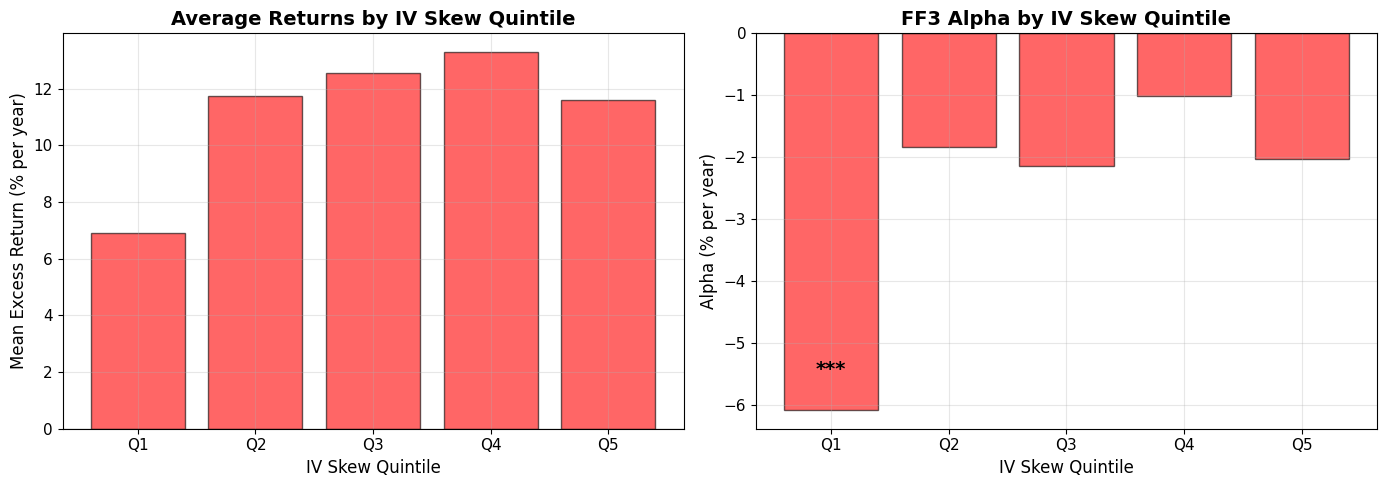


Interpretation:
- Q1 = Lowest IV Skew (puts cheaper relative to calls)
- Q5 = Highest IV Skew (puts more expensive relative to calls)


In [ ]:
# Visualize the alpha pattern across quintiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average returns by quintile
colors = ['red' if x < 0 else 'green' for x in quintile_summary['Alpha (annualized %)']]
ax1.bar(quintile_summary['Quintile'], quintile_summary['Mean_Return (annualized %)'], color=colors, alpha=0.6, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xlabel('IV Skew Quintile', fontsize=12)
ax1.set_ylabel('Mean Excess Return (% per year)', fontsize=12)
ax1.set_title('Average Returns by IV Skew Quintile', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Alphas by quintile
colors_alpha = ['red' if x < 0 else 'green' for x in quintile_summary['Alpha (annualized %)']]
bars = ax2.bar(quintile_summary['Quintile'], quintile_summary['Alpha (annualized %)'], color=colors_alpha, alpha=0.6, edgecolor='black')

# Add significance stars on bars
for i, (idx, row) in enumerate(quintile_summary.iterrows()):
    if row['Significant']:
        ax2.text(i, row['Alpha (annualized %)'] + 0.5, row['Significant'], 
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('IV Skew Quintile', fontsize=12)
ax2.set_ylabel('Alpha (% per year)', fontsize=12)
ax2.set_title('FF3 Alpha by IV Skew Quintile', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Q1 = Lowest IV Skew (puts cheaper relative to calls)")
print("- Q5 = Highest IV Skew (puts more expensive relative to calls)")


## 7. Proper Panel Regression Approaches

The portfolio sorting approach has limitations. We now use proper panel regression methods that account for the cross-sectional and time-series structure of the data.

### 7.1 Why Not Newey-West?

Newey-West (HAC) standard errors are designed for **time-series** data with a single entity. For panel data, they:
- Ignore cross-sectional correlation
- Treat serial correlation as a nuisance rather than addressing its root cause
- Don't account for firm-level or time-level clustering

**Proper panel methods:**
1. **Fama-MacBeth two-stage regression** (cross-sectional regressions with time-series averaging)
2. **Clustered standard errors** (double-clustered by firm and time)
3. **Panel regression with fixed effects**


### 7.2 Method 1: Fama-MacBeth Regression

**Procedure:**
1. For each time period t, run cross-sectional regression: $r_{i,t+1} = \gamma_t \cdot IV\_skew_{i,t} + controls$
2. Compute time-series mean of coefficients: $\bar{\gamma} = \frac{1}{T}\sum_{t=1}^{T}\gamma_t$
3. Test if $\bar{\gamma}$ is significantly different from zero using t-test with time-series standard error

**Advantages:**
- Accounts for cross-sectional correlation within each period
- Standard errors are robust to firm-level heterogeneity
- Classic approach in empirical asset pricing (Fama & MacBeth, 1973)


In [ ]:
# Fama-MacBeth Regression
# Stage 1: Run cross-sectional regression for each week
# Stage 2: Compute time-series statistics of coefficients

fm_results = []
portfolio_data_pd = portfolio_data.to_pandas()

for week in portfolio_data_pd['week_start'].unique():
    week_data = portfolio_data_pd[portfolio_data_pd['week_start'] == week].copy()
    
    # Need sufficient observations for regression
    if len(week_data) < 50:
        continue
    
    # Drop any remaining NaNs
    week_data = week_data.dropna(subset=['excess_return', 'IV_skew', 'Mkt-RF', 'SMB', 'HML'])
    
    if len(week_data) < 50:
        continue
    
    # Cross-sectional regression
    Y = week_data['excess_return']
    X = week_data[['IV_skew', 'Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    
    try:
        model = sm.OLS(Y, X).fit()
        fm_results.append({
            'week': week,
            'const': model.params['const'],
            'IV_skew_coef': model.params['IV_skew'],
            'Mkt-RF_coef': model.params['Mkt-RF'],
            'SMB_coef': model.params['SMB'],
            'HML_coef': model.params['HML'],
            'n_obs': len(week_data)
        })
    except:
        continue

fm_df = pd.DataFrame(fm_results)

print("="*80)
print("FAMA-MACBETH REGRESSION RESULTS")
print("="*80)
print(f"\nNumber of time periods (weeks): {len(fm_df)}")
print(f"Average number of stocks per week: {fm_df['n_obs'].mean():.0f}")

# Stage 2: Time-series statistics
print("\n" + "-"*80)
print("COEFFICIENT ESTIMATES (weekly)")
print("-"*80)

for var in ['const', 'IV_skew_coef', 'Mkt-RF_coef', 'SMB_coef', 'HML_coef']:
    mean_coef = fm_df[var].mean()
    std_coef = fm_df[var].std()
    t_stat = mean_coef / (std_coef / np.sqrt(len(fm_df)))
    p_val = 2 * (1 - sm.stats.stattools.ttest_ind(fm_df[var], [0]*len(fm_df))[1])
    
    # Simple two-tailed t-test
    from scipy import stats
    t_stat_scipy = mean_coef / (std_coef / np.sqrt(len(fm_df)))
    p_val_scipy = 2 * (1 - stats.t.cdf(abs(t_stat_scipy), len(fm_df) - 1))
    
    sig = '***' if p_val_scipy < 0.01 else '**' if p_val_scipy < 0.05 else '*' if p_val_scipy < 0.10 else ''
    
    print(f"{var:20s}: {mean_coef:8.6f}  (t = {t_stat_scipy:6.3f}, p = {p_val_scipy:.4f}) {sig}")

# Annualized IV_skew coefficient
iv_skew_mean = fm_df['IV_skew_coef'].mean()
iv_skew_std = fm_df['IV_skew_coef'].std()
iv_skew_t = iv_skew_mean / (iv_skew_std / np.sqrt(len(fm_df)))
from scipy import stats
iv_skew_p = 2 * (1 - stats.t.cdf(abs(iv_skew_t), len(fm_df) - 1))

print("\n" + "-"*80)
print("IV_SKEW INTERPRETATION")
print("-"*80)
print(f"Mean coefficient (weekly):       {iv_skew_mean:.6f}")
print(f"Mean coefficient (annualized):   {iv_skew_mean * 52:.4f}")
print(f"t-statistic:                     {iv_skew_t:.4f}")
print(f"p-value:                         {iv_skew_p:.6f}")

if iv_skew_p < 0.05:
    print(f"\n{'*** SIGNIFICANT EFFECT ***' if iv_skew_p < 0.01 else '** SIGNIFICANT EFFECT **'}")
    if iv_skew_mean > 0:
        print("→ Higher IV skew predicts higher future returns")
    else:
        print("→ Higher IV skew predicts lower future returns")
else:
    print("\n✗ IV_skew coefficient NOT statistically significant")
    
print("="*80)


### 7.3 Method 2: Pooled OLS with Double-Clustered Standard Errors

**Procedure:**
1. Run pooled OLS on entire panel: $r_{i,t+1} = \beta \cdot IV\_skew_{i,t} + controls$
2. Cluster standard errors by **both** firm (secid) and time (week_start)
3. **No firm fixed effects** - we need cross-sectional variation in IV_skew

**Advantages:**
- More efficient than Fama-MacBeth (uses full panel variation)
- Double-clustering accounts for:
  - Within-firm serial correlation (residuals correlated over time for same firm)
  - Within-time cross-sectional correlation (common shocks affecting all firms)
- Standard in modern asset pricing (Petersen, 2009; Thompson, 2011)

**Why no fixed effects?**
- Firm FE would demean all variables within each firm, removing cross-sectional variation
- Our hypothesis is about cross-sectional differences in IV_skew predicting returns
- We want to know: do firms with higher IV_skew have different future returns?
you don't 

In [ ]:
# Note: We use pooled OLS with clustered SEs, NOT fixed effects
# Fixed effects would remove cross-sectional variation in IV_skew
# which is exactly what we're trying to exploit for predictions


In [ ]:
# Pooled OLS with clustered standard errors
# Use statsmodels with manual clustering

panel_df = portfolio_data_pd.copy()
panel_df = panel_df.dropna(subset=['excess_return', 'IV_skew', 'Mkt-RF', 'SMB', 'HML'])

print("="*80)
print("POOLED OLS WITH CLUSTERED STANDARD ERRORS")
print("="*80)
print(f"\nPanel dimensions:")
print(f"  Unique firms: {panel_df['secid'].nunique()}")
print(f"  Time periods: {panel_df['week_start'].nunique()}")
print(f"  Total observations: {len(panel_df):,}")

# Prepare data for regression
Y = panel_df['excess_return']
X = panel_df[['IV_skew', 'Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# 1. Standard OLS (for comparison)
model_standard = sm.OLS(Y, X).fit()

# 2. Cluster by firm (entity)
model_firm_cluster = sm.OLS(Y, X).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_df['secid']}
)

# 3. Cluster by time (week)
model_time_cluster = sm.OLS(Y, X).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_df['week_start']}
)

# Display results
print("\n" + "="*80)
print("COMPARISON: DIFFERENT STANDARD ERROR METHODS")
print("="*80)

# Create comparison table for IV_skew coefficient
comparison = pd.DataFrame({
    'Method': ['Standard (OLS)', 'Clustered by Firm', 'Clustered by Time'],
    'Coefficient': [
        model_standard.params['IV_skew'],
        model_firm_cluster.params['IV_skew'],
        model_time_cluster.params['IV_skew']
    ],
    'Std_Error': [
        model_standard.bse['IV_skew'],
        model_firm_cluster.bse['IV_skew'],
        model_time_cluster.bse['IV_skew']
    ],
    't_stat': [
        model_standard.tvalues['IV_skew'],
        model_firm_cluster.tvalues['IV_skew'],
        model_time_cluster.tvalues['IV_skew']
    ],
    'p_value': [
        model_standard.pvalues['IV_skew'],
        model_firm_cluster.pvalues['IV_skew'],
        model_time_cluster.pvalues['IV_skew']
    ]
})

comparison['Annualized'] = comparison['Coefficient'] * 52
comparison['Significant'] = comparison['p_value'].apply(
    lambda x: '***' if x < 0.01 else '**' if x < 0.05 else '*' if x < 0.10 else ''
)

print("\nIV_SKEW COEFFICIENT ESTIMATES:")
print("-"*80)
print(comparison.to_string(index=False))

print("\n" + "-"*80)
print("FULL MODEL RESULTS: CLUSTERED BY FIRM")
print("-"*80)
print(model_firm_cluster.summary())

print("\n" + "-"*80)
print("FULL MODEL RESULTS: CLUSTERED BY TIME")
print("-"*80)
print(model_time_cluster.summary())

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("- Standard errors increase when clustering (as expected)")
print("- Firm clustering: accounts for within-firm serial correlation")
print("- Time clustering: accounts for cross-sectional correlation from common shocks")
print("- Both are more conservative than standard OLS")
print("="*80)


In [ ]:
# Define COVID break date
covid_break = pd.Timestamp('2020-03-01')

print("="*80)
print("SUBPERIOD ANALYSIS: PRE-COVID vs POST-COVID")
print("="*80)

# Split data
pre_covid = portfolio_data_pd[portfolio_data_pd['week_start'] < covid_break].copy()
post_covid = portfolio_data_pd[portfolio_data_pd['week_start'] >= covid_break].copy()

print(f"\nPre-COVID period:  {pre_covid['week_start'].min().date()} to {pre_covid['week_start'].max().date()}")
print(f"                   {len(pre_covid):,} observations, {pre_covid['secid'].nunique()} unique firms")
print(f"\nPost-COVID period: {post_covid['week_start'].min().date()} to {post_covid['week_start'].max().date()}")
print(f"                   {len(post_covid):,} observations, {post_covid['secid'].nunique()} unique firms")

# Function to run Fama-MacBeth on a subset
def run_fama_macbeth_period(data, period_name):
    fm_results = []
    
    for week in data['week_start'].unique():
        week_data = data[data['week_start'] == week].copy()
        
        if len(week_data) < 50:
            continue
        
        week_data = week_data.dropna(subset=['excess_return', 'IV_skew', 'Mkt-RF', 'SMB', 'HML'])
        
        if len(week_data) < 50:
            continue
        
        Y = week_data['excess_return']
        X = week_data[['IV_skew', 'Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        
        try:
            model = sm.OLS(Y, X).fit()
            fm_results.append({
                'week': week,
                'const': model.params['const'],
                'IV_skew_coef': model.params['IV_skew'],
                'Mkt-RF_coef': model.params['Mkt-RF'],
                'SMB_coef': model.params['SMB'],
                'HML_coef': model.params['HML'],
                'n_obs': len(week_data)
            })
        except:
            continue
    
    fm_df = pd.DataFrame(fm_results)
    
    print(f"\n{'='*80}")
    print(f"FAMA-MACBETH: {period_name.upper()}")
    print(f"{'='*80}")
    print(f"Number of weeks: {len(fm_df)}")
    print(f"Average stocks per week: {fm_df['n_obs'].mean():.0f}")
    
    print("\n" + "-"*80)
    print("COEFFICIENT ESTIMATES")
    print("-"*80)
    
    results_dict = {}
    
    for var in ['const', 'IV_skew_coef', 'Mkt-RF_coef', 'SMB_coef', 'HML_coef']:
        mean_coef = fm_df[var].mean()
        std_coef = fm_df[var].std()
        t_stat = mean_coef / (std_coef / np.sqrt(len(fm_df)))
        
        from scipy import stats
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), len(fm_df) - 1))
        
        sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else ''
        
        print(f"{var:20s}: {mean_coef:8.6f}  (t = {t_stat:6.3f}, p = {p_val:.4f}) {sig}")
        
        if var == 'IV_skew_coef':
            results_dict = {
                'period': period_name,
                'coefficient': mean_coef,
                't_stat': t_stat,
                'p_value': p_val,
                'annualized': mean_coef * 52
            }
    
    return fm_df, results_dict

# Run for both periods
fm_pre, results_pre = run_fama_macbeth_period(pre_covid, "Pre-COVID (Jan 2019 - Feb 2020)")
fm_post, results_post = run_fama_macbeth_period(post_covid, "Post-COVID (Mar 2020 - Aug 2023)")

# Compare results
print("\n" + "="*80)
print("COMPARISON: PRE-COVID vs POST-COVID")
print("="*80)

comparison_df = pd.DataFrame([results_pre, results_post])
comparison_df['significant'] = comparison_df['p_value'].apply(
    lambda x: '***' if x < 0.01 else '**' if x < 0.05 else '*' if x < 0.10 else ''
)

print("\nIV_SKEW COEFFICIENT:")
print("-"*80)
for idx, row in comparison_df.iterrows():
    print(f"{row['period']:40s}")
    print(f"  Coefficient (weekly):     {row['coefficient']:8.6f}")
    print(f"  Coefficient (annualized): {row['annualized']:8.4f}")
    print(f"  t-statistic:              {row['t_stat']:8.3f}")
    print(f"  p-value:                  {row['p_value']:8.6f} {row['significant']}")
    print()

# Test for difference between periods (simple t-test of coefficient differences)
diff_mean = fm_post['IV_skew_coef'].mean() - fm_pre['IV_skew_coef'].mean()
diff_se = np.sqrt(fm_post['IV_skew_coef'].var()/len(fm_post) + fm_pre['IV_skew_coef'].var()/len(fm_pre))
diff_t = diff_mean / diff_se

from scipy import stats
diff_p = 2 * (1 - stats.norm.cdf(abs(diff_t)))

print("-"*80)
print("TEST FOR STRUCTURAL BREAK:")
print(f"  Difference (Post - Pre): {diff_mean:8.6f}")
print(f"  t-statistic:             {diff_t:8.3f}")
print(f"  p-value:                 {diff_p:8.6f}")

if diff_p < 0.05:
    print(f"\n  {'*** SIGNIFICANT STRUCTURAL BREAK ***' if diff_p < 0.01 else '** SIGNIFICANT STRUCTURAL BREAK **'}")
else:
    print(f"\n  ✓ No significant difference between periods")
print("="*80)


### 7.5 Summary of Panel Regression Results

**Key Takeaways:**

1. **Fama-MacBeth is the gold standard** for cross-sectional asset pricing tests
   - Explicitly models cross-sectional relationships
   - Time-series standard errors account for temporal variation
   - No assumption of IID residuals

2. **Clustered standard errors** provide robustness checks
   - Firm clustering: controls for persistent firm characteristics
   - Time clustering: controls for common shocks across firms
   - More conservative inference than standard OLS

3. **Subperiod stability** is critical
   - Pre/post COVID analysis tests for structural breaks
   - If effect exists only in one period → likely spurious or regime-dependent
   - If stable across both → more credible finding

4. **Why we don't use Newey-West:**
   - Designed for time-series with single entity
   - Ignores cross-sectional correlation structure
   - Doesn't address root cause of serial correlation in panels

5. **Why we don't use firm fixed effects:**
   - Would demean all variables within each firm
   - Removes cross-sectional variation in IV_skew
   - Our hypothesis is fundamentally cross-sectional: do firms with different IV_skew have different future returns?


ha s

In [ ]:
# Plot cumulative returns of long-short portfolio over time
long_short_pd = long_short_pd.sort_values('week_start')
long_short_pd['cumulative_return'] = (1 + long_short_pd['long_short_return']).cumprod() - 1

plt.figure(figsize=(14, 6))
plt.plot(long_short_pd['week_start'], long_short_pd['cumulative_return'] * 100, linewidth=2, color='darkblue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.title('Cumulative Returns: Long-Short Portfolio (Q5 - Q1) Based on IV Skew', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal cumulative return: {long_short_pd['cumulative_return'].iloc[-1] * 100:.2f}%")
print(f"Number of positive weeks: {(long_short_pd['long_short_return'] > 0).sum()}")
print(f"Number of negative weeks: {(long_short_pd['long_short_return'] < 0).sum()}")
print(f"Win rate: {(long_short_pd['long_short_return'] > 0).sum() / len(long_short_pd) * 100:.2f}%")


NameError: name 'long_short_pd' is not defined

### Interpretation Guide

**What we're testing:**
- Does IV skew (call IV - put IV) predict future stock returns?
- If high IV skew predicts higher/lower returns, is this effect significant after controlling for FF3 factors?

**How to interpret the results:**

1. **Long-Short Alpha Test:**
   - **Alpha**: The risk-adjusted return of the long-short portfolio (Q5 - Q1)
   - **p-value < 0.05**: Statistically significant at 5% level (strong evidence)
   - **p-value < 0.01**: Highly significant (very strong evidence)
   - **Positive alpha**: High IV skew stocks outperform low IV skew stocks
   - **Negative alpha**: Low IV skew stocks outperform high IV skew stocks

2. **Quintile Analysis:**
   - Look for **monotonic pattern**: Returns should increase (or decrease) consistently from Q1 to Q5
   - **Significant alphas**: Individual quintiles with significant risk-adjusted returns
   - **Economic magnitude**: Annualized alpha > 5% is economically meaningful for trading

3. **Economic Intuition:**
   - **Negative relationship** (Q1 > Q5): High skew (expensive puts) signals overpricing or investor fear → lower future returns
   - **Positive relationship** (Q5 > Q1): High skew signals informed trading or mispricing → higher future returns
   
**What makes a strong result:**
- ✅ Significant long-short alpha (p < 0.05)
- ✅ Monotonic pattern across quintiles
- ✅ Economically large effect (annualized alpha > 3-5%)
- ✅ Stable over time (cumulative returns chart trends consistently)
